In [1]:
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt

import folium

import os
import random
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"  # disable info log from tensorflow
import tensorflow as tf
from modules.DatasetWrapper import Dataset, Log
from modules.TrainOnOneSite import Trainer
from modules.kerasGenerator import plot_model_info
from IPython.display import Markdown, display
from modules.Plotter import OnePlotter, GeneralPlotter

In [2]:
data = gpd.read_file('../data/map.geojson')

# Plot mappa - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
marker_colors = {"SIGNALISED T-JUNCTION" : "red", "SIGNALISED 4 WAY INTERSECTION": "green", "SIGNALISED PEDESTRIAN CROSSING" :"blue"}

map = folium.Map(location=[-34.920369,138.6007179], zoom_start=14)
folium.GeoJson(
    data,
    name = "Site info",
    zoom_on_click = False,
    popup=folium.GeoJsonPopup(fields=["site"]),
).add_to(map)
display(map)

In [3]:
data = Dataset()

#### Site selection
the select_multiple_site function has as its first argument an array of neighboring sites, whereas as its second argument the target site.
Its output is the dataframe containing the traffic of the sites with contextual information and X represents all the input features while Y represents all the output features

In [4]:
data_set, X, Y = data.select_multiple_site([9,11], [10])
print(X)
print(Y)

,date,target_10,temperature_2m,apparent_temperature,relative_humidity_2m,precipitation,wind_speed_10m,cloud_cover,holiday,hour_of_day(sin),hour_of_day(cos),day_of_week(sin),day_of_week(cos),site_9,site_11
0,2010-01-01 00:00:00,0.337778,1.1770,1.222295,0.524240,0.0,0.524168,0.009,1.0,0.500000,1.000000,0.283058,0.049516,0.342778,0.427778
1,2010-01-01 01:00:00,0.320000,1.2745,1.343040,0.477259,0.0,0.747476,0.000,1.0,0.629410,0.982963,0.283058,0.049516,0.331667,0.433889
2,2010-01-01 02:00:00,0.220000,1.3520,1.412889,0.448419,0.0,1.099294,0.000,1.0,0.750000,0.933013,0.283058,0.049516,0.207222,0.301667
3,2010-01-01 03:00:00,0.147778,1.3895,1.434875,0.437566,0.0,1.345927,0.000,1.0,0.853553,0.853553,0.283058,0.049516,0.146667,0.201111
4,2010-01-01 04:00:00,0.133889,1.3995,1.424755,0.436701,0.0,1.493795,0.000,1.0,0.933013,0.750000,0.283058,0.049516,0.140000,0.175556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2014-12-31 19:00:00,0.438333,0.9045,0.809185,0.573908,0.0,0.819170,0.294,0.0,0.017037,0.629410,0.987464,0.388740,0.454444,0.633889
43820,2014-12-31 20:00:00,0.326111,0.9270,0.825308,0.546799,0.0,0.839657,0.279,0.0,0.066987,0.750000,0.987464,0.388740,0.363333,0.546667
43821,2014-12-31 21:00:00,0.311111,1.0020,0.909157,0.504800,0.0,0.783592,0.291,0.0,0.146447,0.853553,0.987464,0.388740,0.353333,0.497778
43822,2014-12-31 22:00:00,0.382778,1.1495,1.102550,0.431425,0.0,0.408000,0.273,0.0,0.250000,0.933013,0.987464,0.388740,0.410000,0.675000


['site_9', 'site_11', 'hour_of_day(sin)', 'hour_of_day(cos)', 'day_of_week(sin)', 'day_of_week(cos)', 'holiday', 'temperature_2m', 'apparent_temperature', 'relative_humidity_2m', 'precipitation', 'wind_speed_10m', 'cloud_cover']
['target_10']


#### Correlation between roads

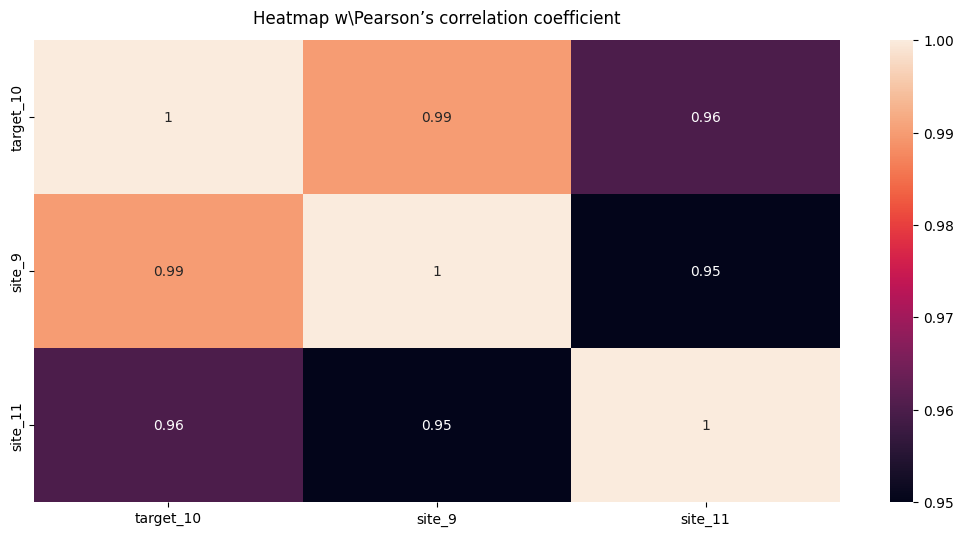

In [5]:
temp = data_set.copy()
temp[Y[0]] = temp[Y[0]].shift(-1)
# --- --- --- --- pearson
plt.figure(figsize=(13, 6))
rounded_corr_matrix = data_set.drop(columns=["date", 'temperature_2m', 'apparent_temperature', 'relative_humidity_2m', 'precipitation', 'wind_speed_10m', 'cloud_cover', 'holiday', 'hour_of_day(sin)', 'hour_of_day(cos)', 'day_of_week(sin)', 'day_of_week(cos)']).corr(method='pearson').round(2)
heatmap = sns.heatmap(rounded_corr_matrix, annot=True)
heatmap.set_title('Heatmap w\\Pearson’s correlation coefficient', fontdict={'fontsize':12}, pad=12)
plt.savefig('img/temp/heapmap.svg')

del rounded_corr_matrix, heatmap, temp

### Window creation
- Test1 = window used as a test for level 0 architectures, contains the last 3 years of the dataset
- Train2, Valid2 = are the training_set and validation_set of level 0, containing respectively the first two years and the third year of the dataset
- Train, Valid, Test = classic division of the dataset 3 years train, 1 year validation, 1 year test

In [6]:
input_len = Trainer.NEW_X_WINDOWS

_, _, Test1 =  data.split_and_get_generators_multi(data_set,training = 2, validation = 0, test= 3, X_col=X, y_col=Y, input_size=input_len, stop=False)
Train2, Valid2, Test2 =  data.split_and_get_generators_multi(data_set,training = 2, validation = 1, test= 1, X_col=X, y_col=Y, input_size=input_len, stop=True)

Train, Valid, Test = data.split_and_get_generators_multi(data_set, X_col=X, y_col=Y, input_size=input_len)

## Training level 0 models

In [7]:
patience_RLR = 2
patience_ES = 6
epochs = 6
plot_range = range(7673,8173)
sv_model = False
sv_step = False

trainer = Trainer(Train2, Valid2, Test2)

### Stacked LSTM



Training:



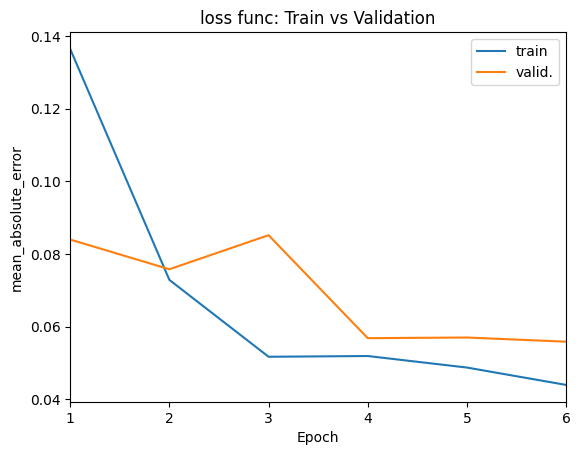

546/546 - 35s - 64ms/step - loss: 0.0042 - mean_absolute_error: 0.0440 - val_loss: 0.0062 - val_mean_absolute_error: 0.0559 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 6.

Training Score:
546/546 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step
mean_squared_error: 0.0054(0.0735) - mean_absolute_error: 0.0520
DeNorm_mean_squared_error: 17357.6816(131.7486) - DeNorm_mean_absolute_error: 93.6125


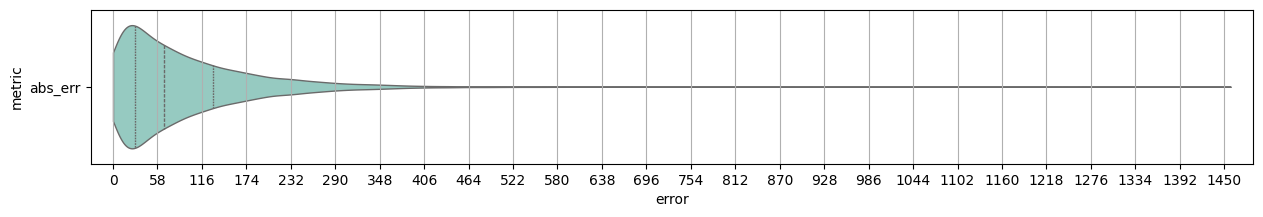

,mean,std,min,25%,50%,75%,max
error,93.612527,92.708508,0.00559,28.475579,66.25413,130.204615,1458.569288



Validation Score:
273/273 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step
mean_squared_error: 0.0062(0.0787) - mean_absolute_error: 0.0559
DeNorm_mean_squared_error: 19968.5586(141.3102) - DeNorm_mean_absolute_error: 100.5387


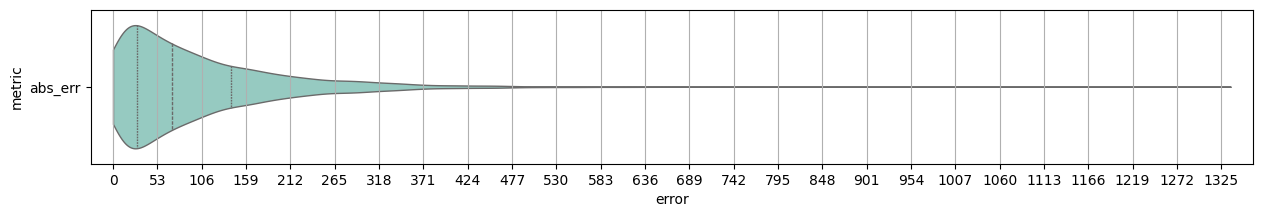

,mean,std,min,25%,50%,75%,max
error,100.53866,99.305916,0.000809,29.167584,69.951753,141.225472,1336.391767



Test Score:
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step
mean_squared_error: 0.0097(0.0985) - mean_absolute_error: 0.0718
DeNorm_mean_squared_error: 31476.0156(177.4148) - DeNorm_mean_absolute_error: 129.2671


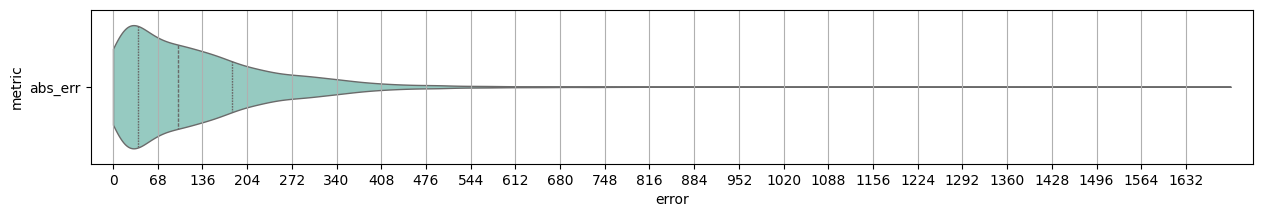

,mean,std,min,25%,50%,75%,max
error,129.267085,121.522555,0.000178,38.449943,98.301865,181.266283,1700.245717


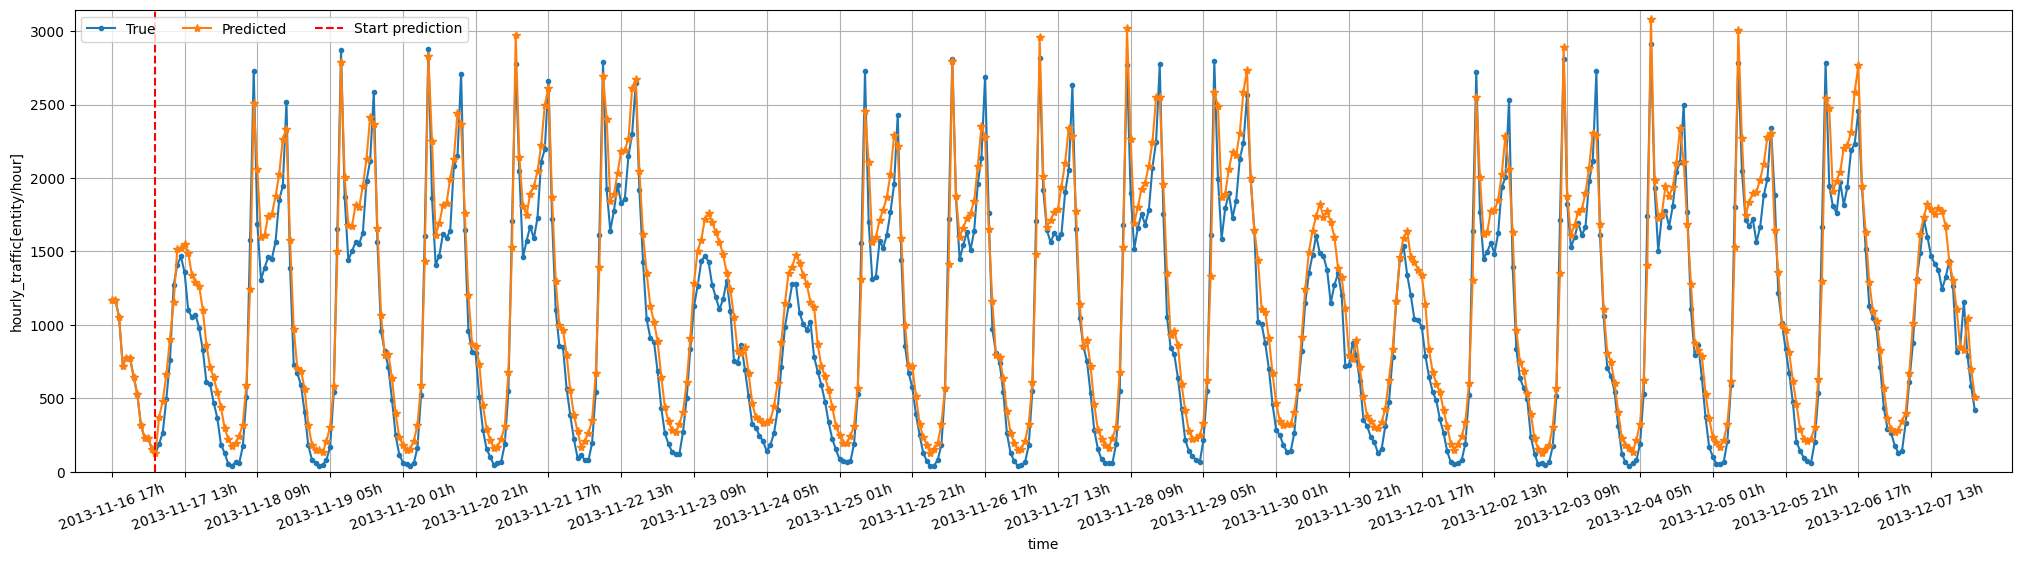

In [8]:
model_stacked_lstm = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(trainer.shape_X)),
    tf.keras.layers.LSTM(units=256, return_sequences=True),
    tf.keras.layers.LSTM(units=256, return_sequences=False),
    tf.keras.layers.Dense(units=64, activation="linear"),
    tf.keras.layers.Dense(units=trainer.shape_y, activation="linear")
])
model_stacked_lstm.name="Multiple_site_StackedLSTM"
plot_model_info(model_stacked_lstm)
_ = trainer.fit_on(
    on_model         = model_stacked_lstm,
    N_epochs         = epochs,
    patience_RLR     = patience_RLR,
    patience_ES      = patience_ES,
    plot_range = plot_range,
    save_model       = sv_model,
    save_step        = sv_step,
)

### Stacked LSTM modified



Training:



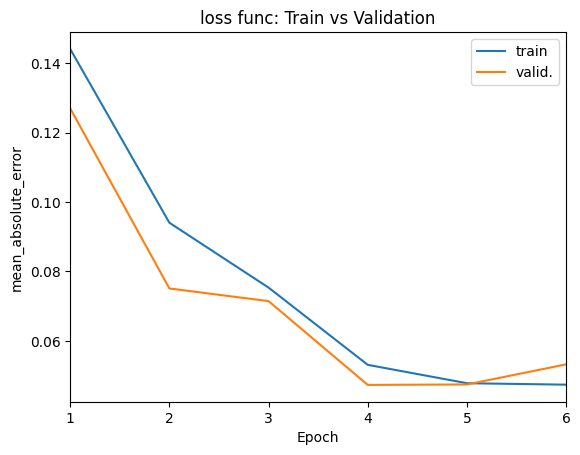


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
546/546 - 30s - 55ms/step - loss: 0.0047 - mean_absolute_error: 0.0474 - val_loss: 0.0056 - val_mean_absolute_error: 0.0532 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 4.

Training Score:
546/546 ━━━━━━━━━━━━━━━━━━━━ 28s 50ms/step
mean_squared_error: 0.0043(0.0656) - mean_absolute_error: 0.0467
DeNorm_mean_squared_error: 14084.2129(118.6769) - DeNorm_mean_absolute_error: 84.0481


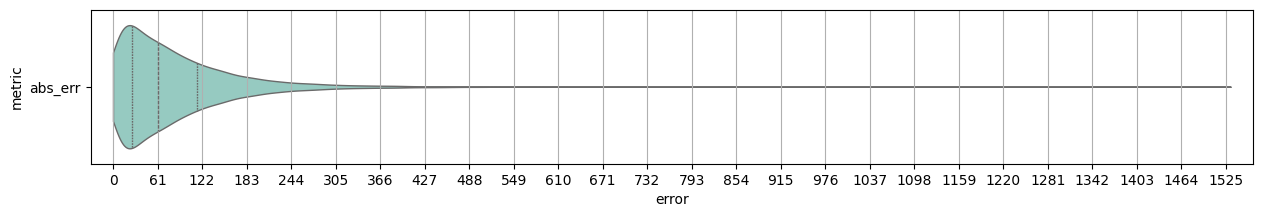

,mean,std,min,25%,50%,75%,max
error,84.048095,83.788616,0.005217,26.527689,61.225291,115.220052,1531.615281



Validation Score:
273/273 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step
mean_squared_error: 0.0043(0.0656) - mean_absolute_error: 0.0473
DeNorm_mean_squared_error: 13918.8691(117.9783) - DeNorm_mean_absolute_error: 85.1471


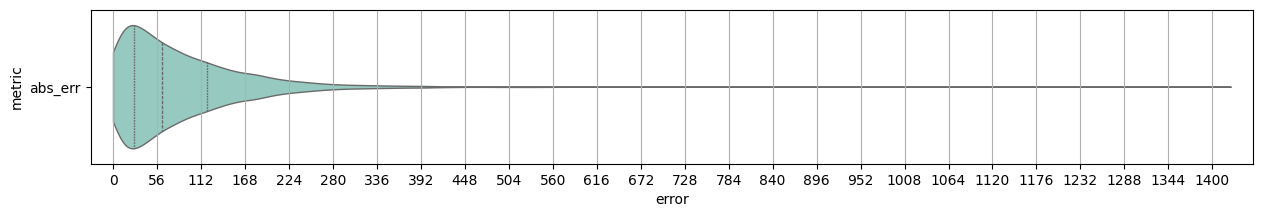

,mean,std,min,25%,50%,75%,max
error,85.147121,81.667616,0.007346,27.062716,61.982476,119.079754,1423.490174



Test Score:
272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step
mean_squared_error: 0.0073(0.0854) - mean_absolute_error: 0.0591
DeNorm_mean_squared_error: 23732.4961(154.0535) - DeNorm_mean_absolute_error: 106.4175


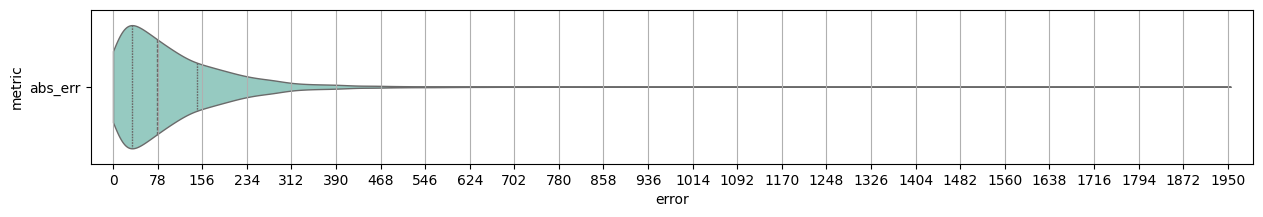

,mean,std,min,25%,50%,75%,max
error,106.417543,111.396717,0.000376,33.647445,76.309682,146.599546,1955.343676


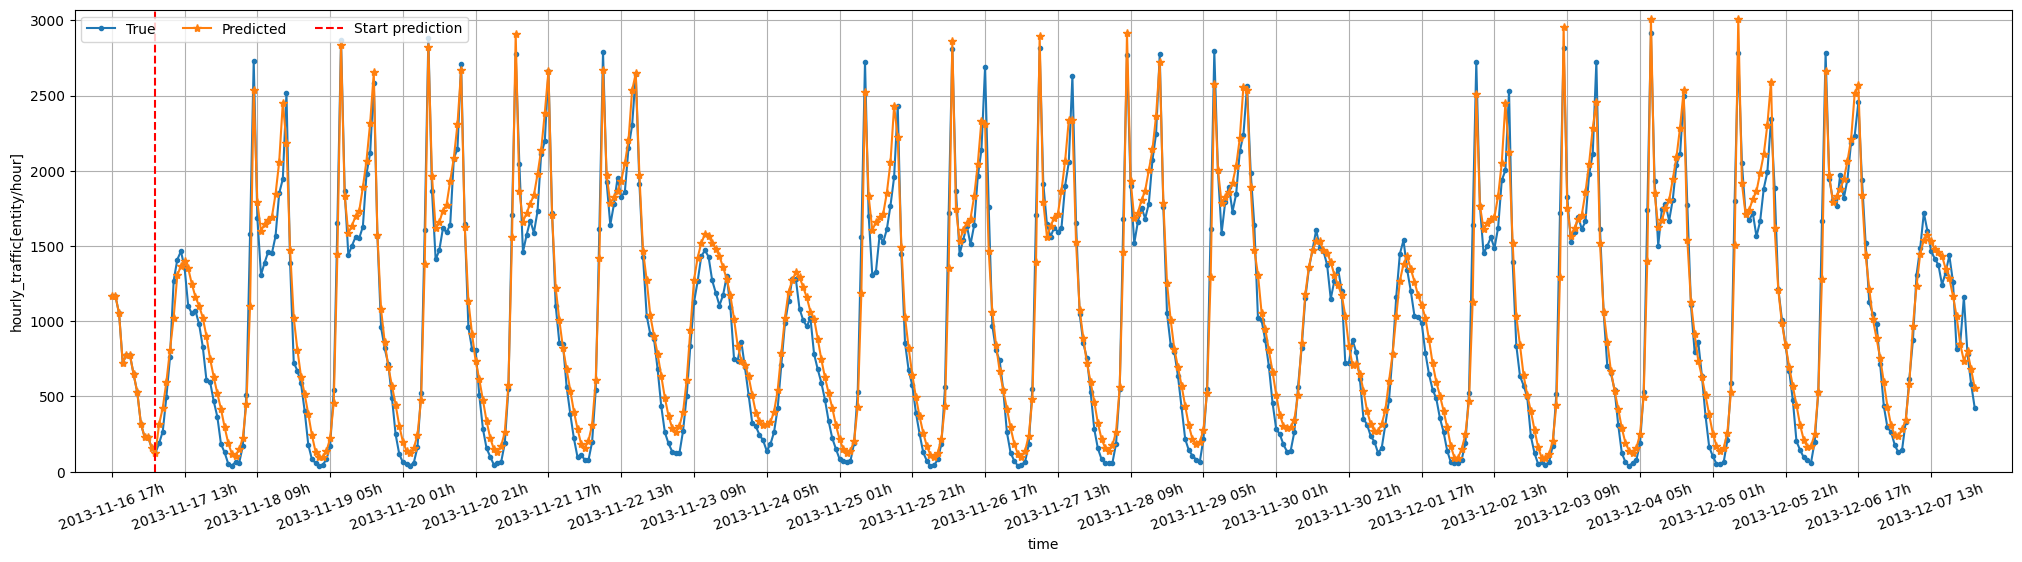

In [9]:
model_lstm_modif = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(trainer.shape_X)),
    tf.keras.layers.LSTM(units=1024, return_sequences=True),
    tf.keras.layers.LSTM(units=512, return_sequences=True),
    tf.keras.layers.LSTM(units=256, return_sequences=False),
    tf.keras.layers.Dense(units=126, activation="linear"),
    tf.keras.layers.Dense(units=trainer.shape_y, activation="linear")
])
model_lstm_modif.name="Multiple_site_StackedLSTM_modif"
plot_model_info(model_lstm_modif)

_ = trainer.fit_on(
    on_model         = model_lstm_modif,
    N_epochs         = epochs,
    patience_RLR     = patience_RLR,
    patience_ES      = patience_ES,
    plot_range       = plot_range,
    save_model       = sv_model,
    save_step        = sv_step,
)

### CNN



Training:



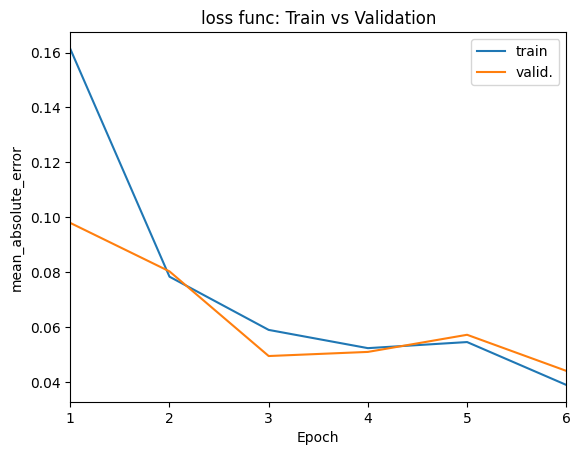

546/546 - 28s - 52ms/step - loss: 0.0035 - mean_absolute_error: 0.0389 - val_loss: 0.0046 - val_mean_absolute_error: 0.0440 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 6.

Training Score:
546/546 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step
mean_squared_error: 0.0032(0.0566) - mean_absolute_error: 0.0366
DeNorm_mean_squared_error: 10365.5420(101.8113) - DeNorm_mean_absolute_error: 65.8461


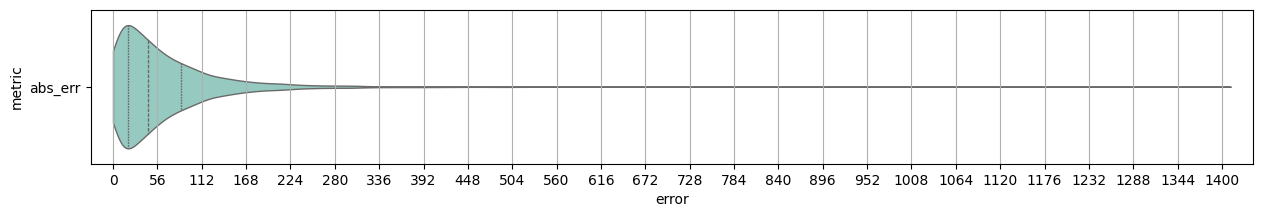

,mean,std,min,25%,50%,75%,max
error,65.846117,77.654205,0.004359,19.084308,44.157873,86.113019,1411.0811



Validation Score:
273/273 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step
mean_squared_error: 0.0046(0.0678) - mean_absolute_error: 0.0440
DeNorm_mean_squared_error: 15038.5518(122.6318) - DeNorm_mean_absolute_error: 79.2537


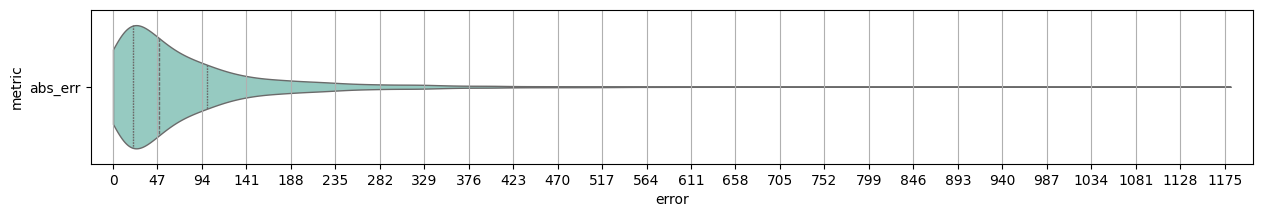

,mean,std,min,25%,50%,75%,max
error,79.253677,93.586371,0.007868,21.479441,48.642997,99.360069,1181.552021



Test Score:
272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step
mean_squared_error: 0.0069(0.0831) - mean_absolute_error: 0.0513
DeNorm_mean_squared_error: 22364.8965(149.5490) - DeNorm_mean_absolute_error: 92.2747


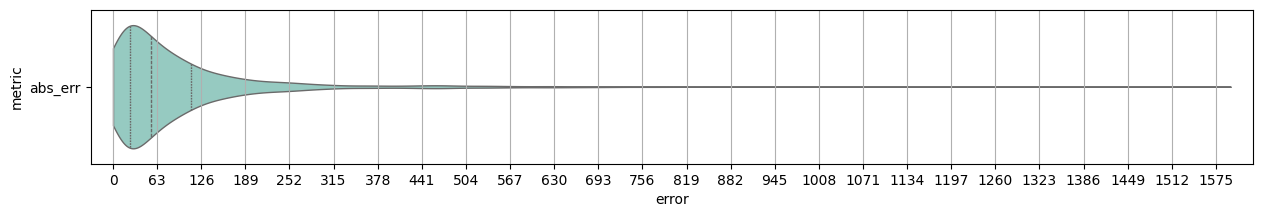

,mean,std,min,25%,50%,75%,max
error,92.274747,117.69393,0.000291,24.076173,54.925412,111.144255,1596.206692


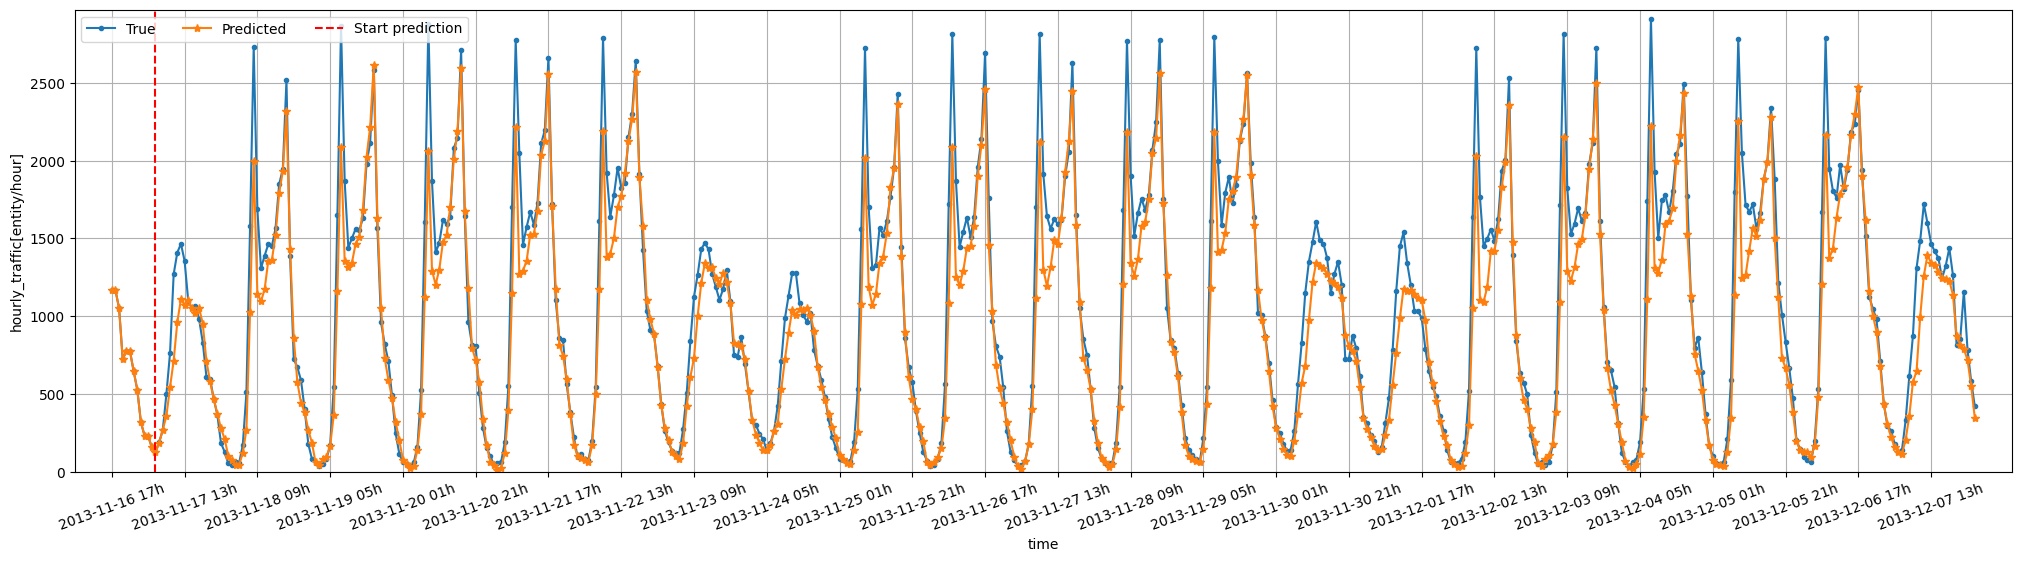

In [10]:
model_CNN = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(13,13,1)),
    tf.keras.layers.Conv2D(256, activation="relu", kernel_size=(int(13/4))),
    tf.keras.layers.Conv2D(256, activation="relu", kernel_size=5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=516, activation="linear"),
    tf.keras.layers.Dense(trainer.shape_y)
])
model_CNN.name="Multiple_site_CNN"
plot_model_info(model_lstm_modif)

_ = trainer.fit_on(
    on_model         = model_CNN,
    N_epochs         = epochs,
    patience_RLR     = patience_RLR,
    patience_ES      = patience_ES,
    plot_range       = plot_range,
    save_model       = sv_model,
    save_step        = sv_step,
)

### Stacked GRU



Training:



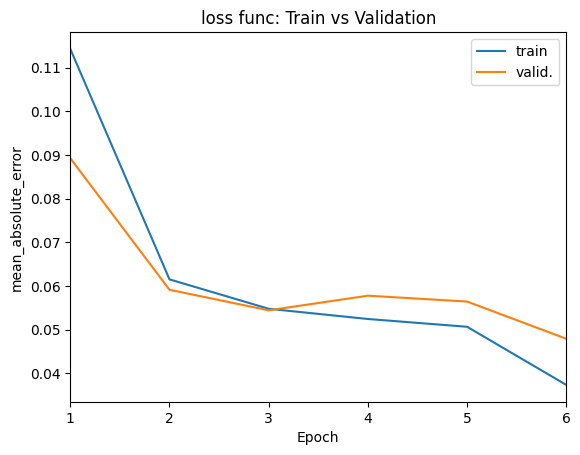

546/546 - 31s - 57ms/step - loss: 0.0031 - mean_absolute_error: 0.0374 - val_loss: 0.0054 - val_mean_absolute_error: 0.0479 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 6.

Training Score:
546/546 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step
mean_squared_error: 0.0029(0.0539) - mean_absolute_error: 0.0358
DeNorm_mean_squared_error: 9475.7666(97.3436) - DeNorm_mean_absolute_error: 64.3503


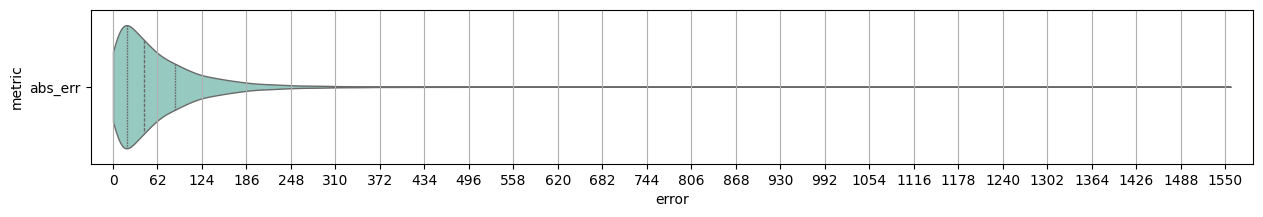

,mean,std,min,25%,50%,75%,max
error,64.35029,73.04185,0.002319,19.360248,43.878695,85.866278,1557.760164



Validation Score:
273/273 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step
mean_squared_error: 0.0054(0.0735) - mean_absolute_error: 0.0479
DeNorm_mean_squared_error: 17601.7441(132.6716) - DeNorm_mean_absolute_error: 86.2935


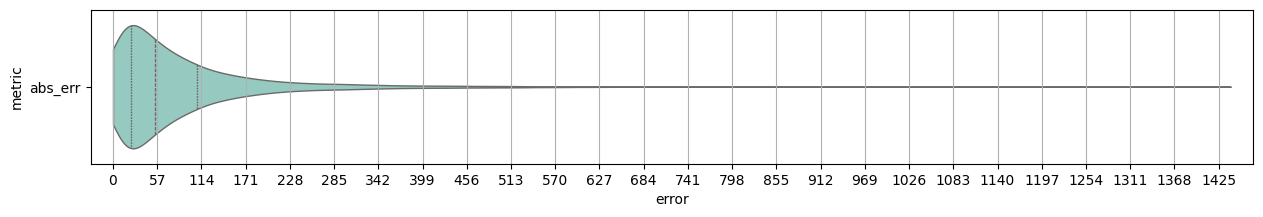

,mean,std,min,25%,50%,75%,max
error,86.293526,100.778635,0.026057,23.412377,54.296516,108.80532,1440.64676



Test Score:
272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step
mean_squared_error: 0.0048(0.0693) - mean_absolute_error: 0.0468
DeNorm_mean_squared_error: 15576.2324(124.8048) - DeNorm_mean_absolute_error: 84.2202


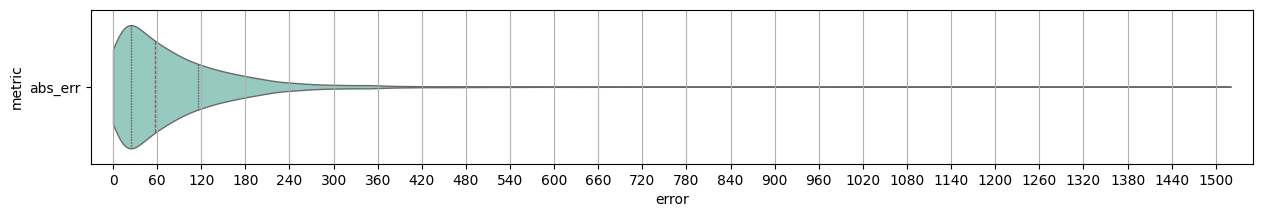

,mean,std,min,25%,50%,75%,max
error,84.220166,92.109553,0.008837,24.370261,57.779683,114.988371,1520.384183


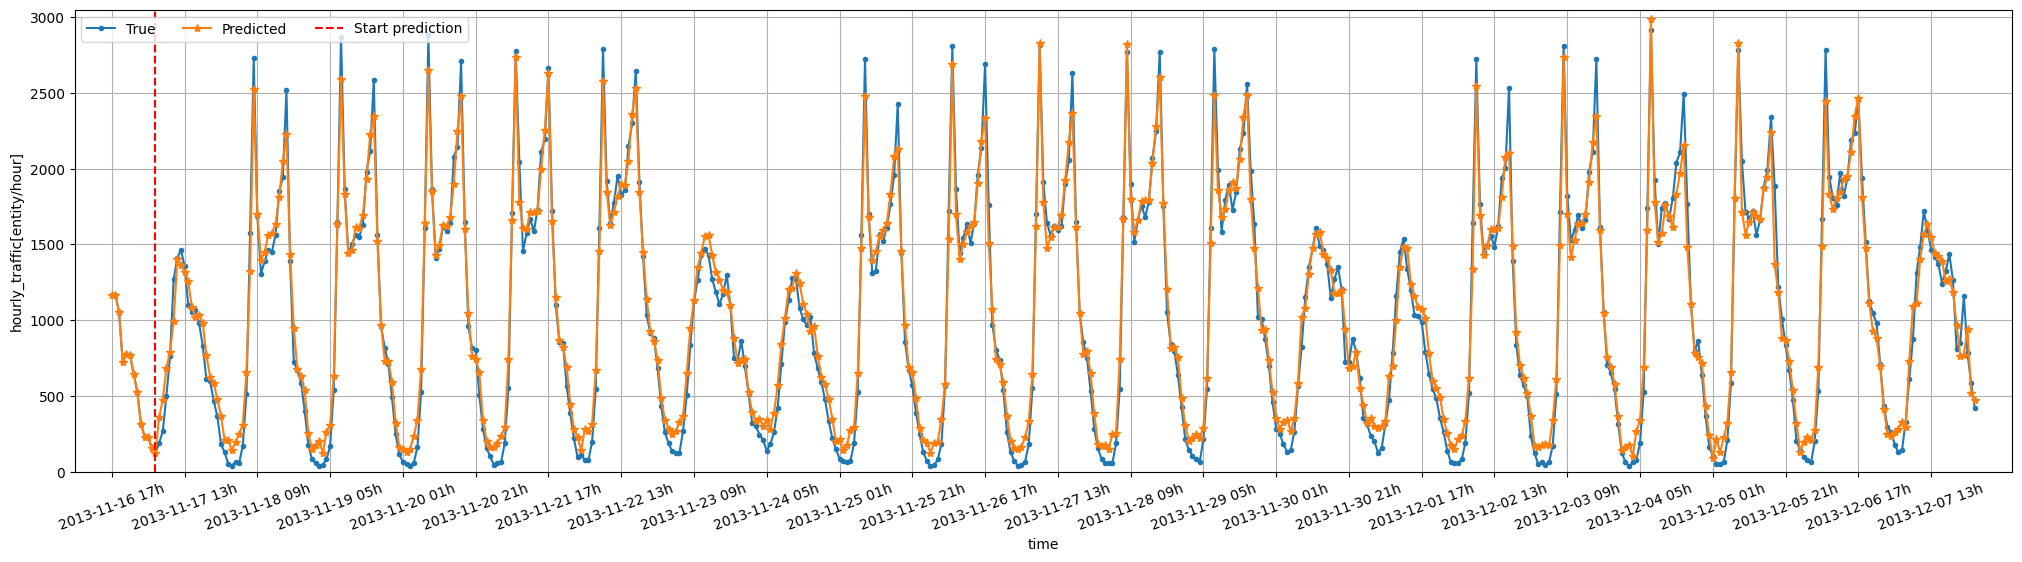

In [11]:
model_GRU = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(trainer.shape_X)),
    tf.keras.layers.GRU(units=256, return_sequences=True),
    tf.keras.layers.GRU(units=256, return_sequences=False),
    tf.keras.layers.Dense(units=64, activation="linear"),
    tf.keras.layers.Dense(units=trainer.shape_y, activation="linear")
])
model_GRU.name="Multiple_site_GRU"
plot_model_info(model_GRU)

_ = trainer.fit_on(
    on_model         = model_GRU,
    N_epochs         = epochs,
    patience_RLR     = patience_RLR,
    patience_ES      = patience_ES,
    plot_range       = plot_range,
    save_model       = sv_model,
    save_step        = sv_step,
)

## Creation of prediction dataset

### prediction of level 0 models stored in vectors

In [12]:
pred_stackedLSTM, _ = trainer.predict_and_compare(model_stacked_lstm, Test1, plot_range, do_plot = False)
#pred_stackedLSTM_modif, _ = trainer.predict_and_compare(model_lstm_modif, Test1, plot_range, do_plot = False)
pred_CNN, _ = trainer.predict_and_compare(model_CNN, Test1, plot_range, do_plot = False)
pred_GRU, _ = trainer.predict_and_compare(model_GRU, Test1, plot_range, do_plot = False)


Prediction Scores:
821/821 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step
mean_squared_error: 0.0094(0.0970) - mean_absolute_error: 0.0739
DeNorm_mean_squared_error: 30547.5801(174.7787) - DeNorm_mean_absolute_error: 133.0493

Prediction Scores:
821/821 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step
mean_squared_error: 0.0098(0.0990) - mean_absolute_error: 0.0588
DeNorm_mean_squared_error: 31791.1289(178.3007) - DeNorm_mean_absolute_error: 105.9014

Prediction Scores:
821/821 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step
mean_squared_error: 0.0056(0.0748) - mean_absolute_error: 0.0531
DeNorm_mean_squared_error: 18274.1543(135.1819) - DeNorm_mean_absolute_error: 95.6410


### Network input organization level 1

#### initial dataframe with only target variable and predictions

We created a dataframe with two columns, one with the target variable corresponding to the prediction made. To do this, we took the last three years of the hourly_traffic corresponding to site 10, removed the first 13 samples corresponding to the window, and removed the last 19 samples because they were not in the predictions, given that the dataset size was not divisible by the batch size, resulting in a remainder of 19 samples not taken.

In [13]:
target = data_set[(data_set['date'] >= "2012-01-01 13:00:00")].reset_index(drop=True)
target = target[[Y[0], 'date']]
target = target[:-19]
target

,target_10,date
0,0.330556,2012-01-01 13:00:00
1,0.350556,2012-01-01 14:00:00
2,0.317222,2012-01-01 15:00:00
3,0.277222,2012-01-01 16:00:00
4,0.278889,2012-01-01 17:00:00
...,...,...
26267,0.074444,2014-12-31 00:00:00
26268,0.042222,2014-12-31 01:00:00
26269,0.027222,2014-12-31 02:00:00
26270,0.026111,2014-12-31 03:00:00


afterwards we inserted columns for the predictions of each model

In [14]:
target['Stk_LSTM'] = pred_stackedLSTM
target['CNN'] = pred_CNN
target['GRU'] = pred_GRU

target.to_csv('../data/Multiple_site_result.csv', index=False)
target

,target_10,date,Stk_LSTM,CNN,GRU
0,0.330556,2012-01-01 13:00:00,0.431594,0.271300,0.362420
1,0.350556,2012-01-01 14:00:00,0.398748,0.232056,0.322199
2,0.317222,2012-01-01 15:00:00,0.389392,0.213563,0.323670
3,0.277222,2012-01-01 16:00:00,0.363857,0.177840,0.307444
4,0.278889,2012-01-01 17:00:00,0.328353,0.140704,0.281369
...,...,...,...,...,...
26267,0.074444,2014-12-31 00:00:00,0.153840,0.062290,0.149835
26268,0.042222,2014-12-31 01:00:00,0.119831,0.036613,0.086849
26269,0.027222,2014-12-31 02:00:00,0.103481,0.009810,0.086181
26270,0.026111,2014-12-31 03:00:00,0.092742,-0.009243,0.071969


#### Creation of input windows

We first divided the dataframe created in the previous section into three parts

In [15]:
dataTrain = target[(target['date'] >= "2012-01-01 13:00:00") & (target['date'] < "2013-01-01 00:00:00")].reset_index(drop=True)
dataValid = target[(target['date'] >= "2013-01-01 13:00:00") & (target['date'] < "2014-01-01 00:00:00")].reset_index(drop=True)
dataTest = target[(target['date'] >= "2014-01-01 13:00:00")].reset_index(drop=True)
dataTrain

,target_10,date,Stk_LSTM,CNN,GRU
0,0.330556,2012-01-01 13:00:00,0.431594,0.271300,0.362420
1,0.350556,2012-01-01 14:00:00,0.398748,0.232056,0.322199
2,0.317222,2012-01-01 15:00:00,0.389392,0.213563,0.323670
3,0.277222,2012-01-01 16:00:00,0.363857,0.177840,0.307444
4,0.278889,2012-01-01 17:00:00,0.328353,0.140704,0.281369
...,...,...,...,...,...
8766,0.466111,2012-12-31 19:00:00,0.387964,0.293407,0.378374
8767,0.378333,2012-12-31 20:00:00,0.356228,0.249560,0.353147
8768,0.366111,2012-12-31 21:00:00,0.292804,0.203090,0.286290
8769,0.337778,2012-12-31 22:00:00,0.267513,0.159206,0.277132


to then create the three input windows using the class developed by us

In [20]:
from modules.kerasGenerator import CustomDataGen

Train2 = CustomDataGen(dataTrain, ['Stk_LSTM', 'CNN', 'GRU'], Y, 32, input_len, 1, -1)
Valid2 = CustomDataGen(dataValid, ['Stk_LSTM', 'CNN', 'GRU'], Y, 32, input_len, 1, -1)
Test2 = CustomDataGen(dataTest, ['Stk_LSTM', 'CNN', 'GRU'], Y, 32, input_len, 1, -1)

## Training of the level 1 model

In [21]:
patience_RLR = 2
patience_ES = 5
epochs = 8
plot_range = range(7673,8173)
sv_model = False
sv_step = False

trainer = Trainer(Train2, Valid2, Test2)

### Generalization network/meta model: Stacked LSTM



Training:



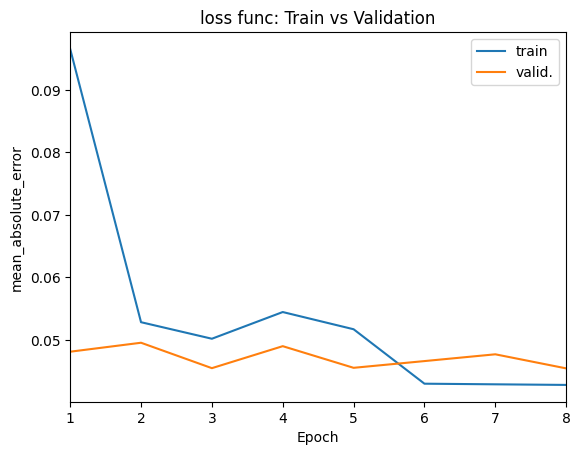


Epoch 8: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
273/273 - 12s - 46ms/step - loss: 0.0040 - mean_absolute_error: 0.0428 - val_loss: 0.0049 - val_mean_absolute_error: 0.0455 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 8.

Training Score:
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
mean_squared_error: 0.0040(0.0632) - mean_absolute_error: 0.0421
DeNorm_mean_squared_error: 13083.7676(114.3843) - DeNorm_mean_absolute_error: 75.7861


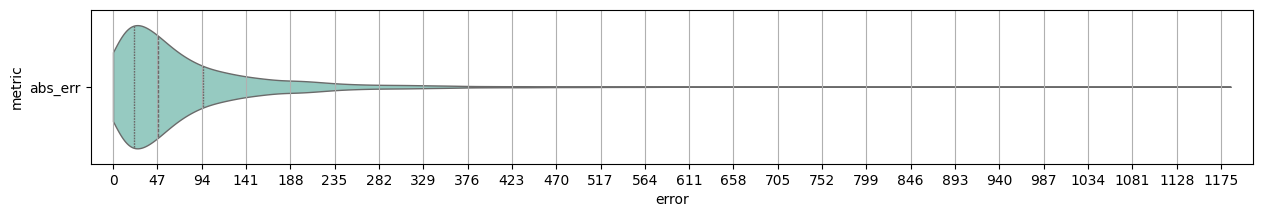

,mean,std,min,25%,50%,75%,max
error,75.786124,85.680048,0.000761,22.249672,47.658875,95.889679,1185.44391



Validation Score:
272/272 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step
mean_squared_error: 0.0049(0.0700) - mean_absolute_error: 0.0455
DeNorm_mean_squared_error: 15766.0508(125.5629) - DeNorm_mean_absolute_error: 81.8221


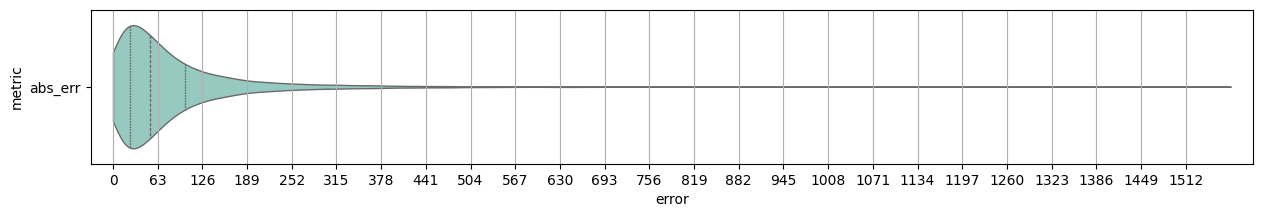

,mean,std,min,25%,50%,75%,max
error,81.82209,95.248303,0.003017,24.629816,52.529985,102.158296,1575.608614



Test Score:
271/271 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step
mean_squared_error: 0.0082(0.0906) - mean_absolute_error: 0.0613
DeNorm_mean_squared_error: 26555.6055(162.9589) - DeNorm_mean_absolute_error: 110.3051


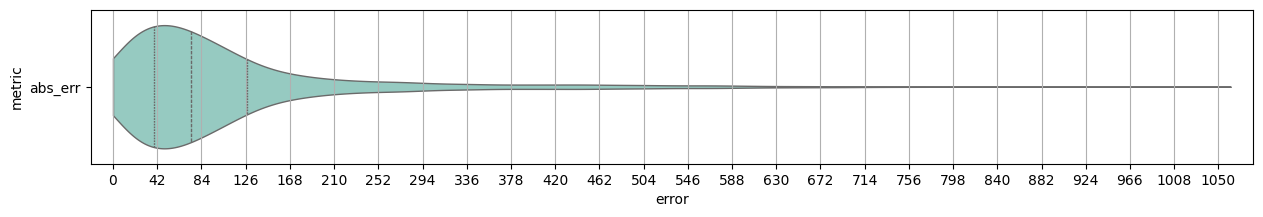

,mean,std,min,25%,50%,75%,max
error,110.305082,119.958543,0.009352,39.045771,73.897508,127.216034,1061.811717


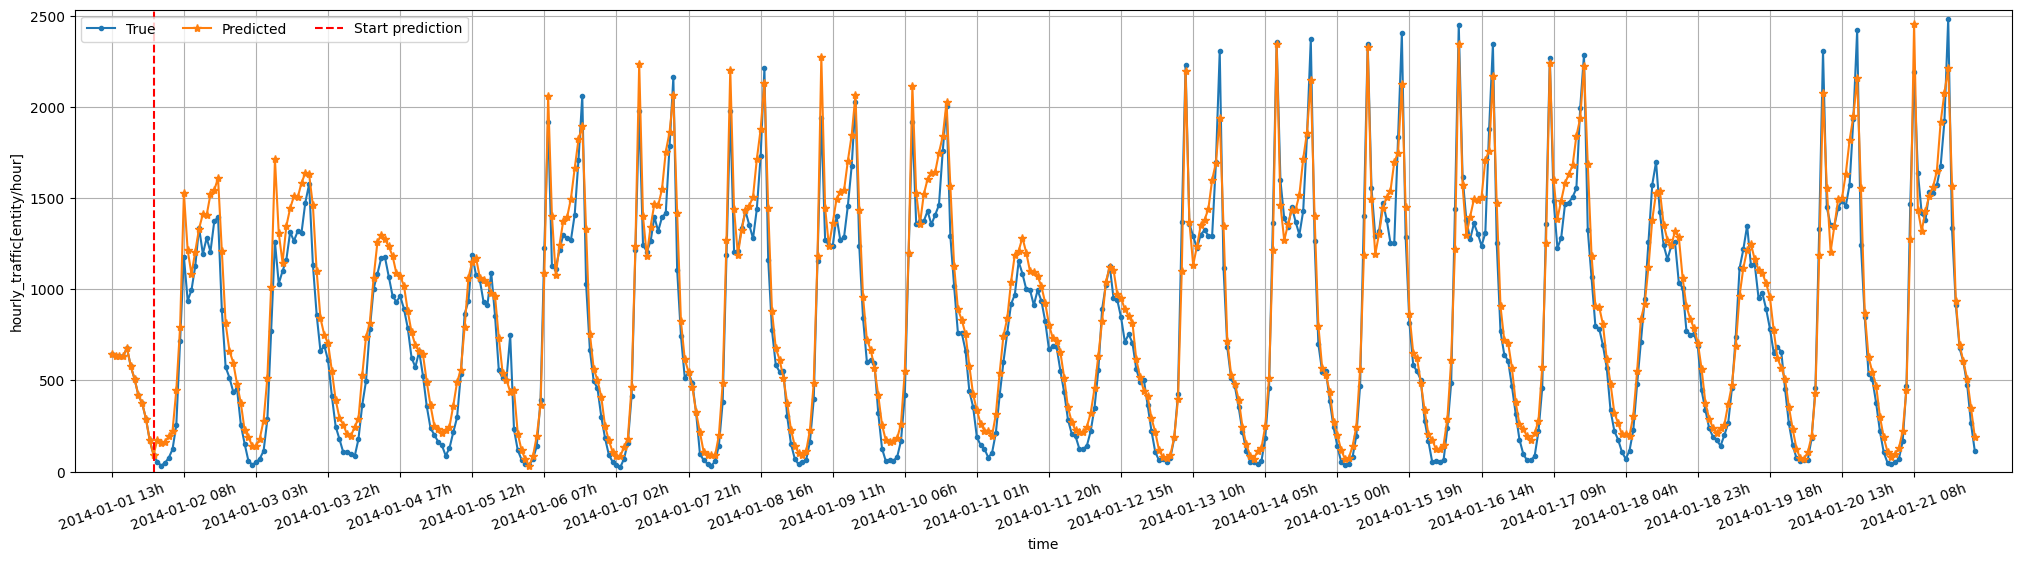

In [22]:
meta_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(trainer.shape_X)),
    tf.keras.layers.LSTM(units=256, return_sequences=True),
    tf.keras.layers.LSTM(units=256, return_sequences=False),
    tf.keras.layers.Dense(units=64, activation="linear"),
    tf.keras.layers.Dense(units=trainer.shape_y, activation="linear")
])
meta_model.name="meta_model"
plot_model_info(meta_model)

_ = trainer.fit_on(
    on_model         = meta_model,
    N_epochs         = epochs,
    patience_RLR     = patience_RLR,
    patience_ES      = patience_ES,
    #plot_range       = plot_range,
    save_model       = sv_model,
    save_step        = sv_step,
)

### Comparison with prediction on the last year for level 0 networks


Prediction Scores:
272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step
mean_squared_error: 0.0123(0.1109) - mean_absolute_error: 0.0938
DeNorm_mean_squared_error: 39995.5703(199.9889) - DeNorm_mean_absolute_error: 168.8713


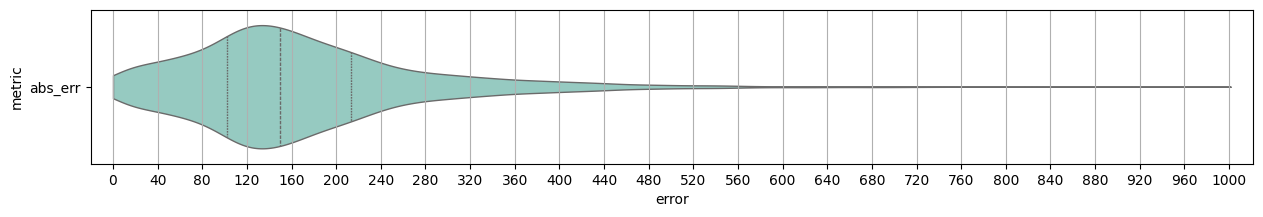

,mean,std,min,25%,50%,75%,max
error,168.871271,107.141873,0.023852,101.737929,149.86744,213.550808,1001.620037


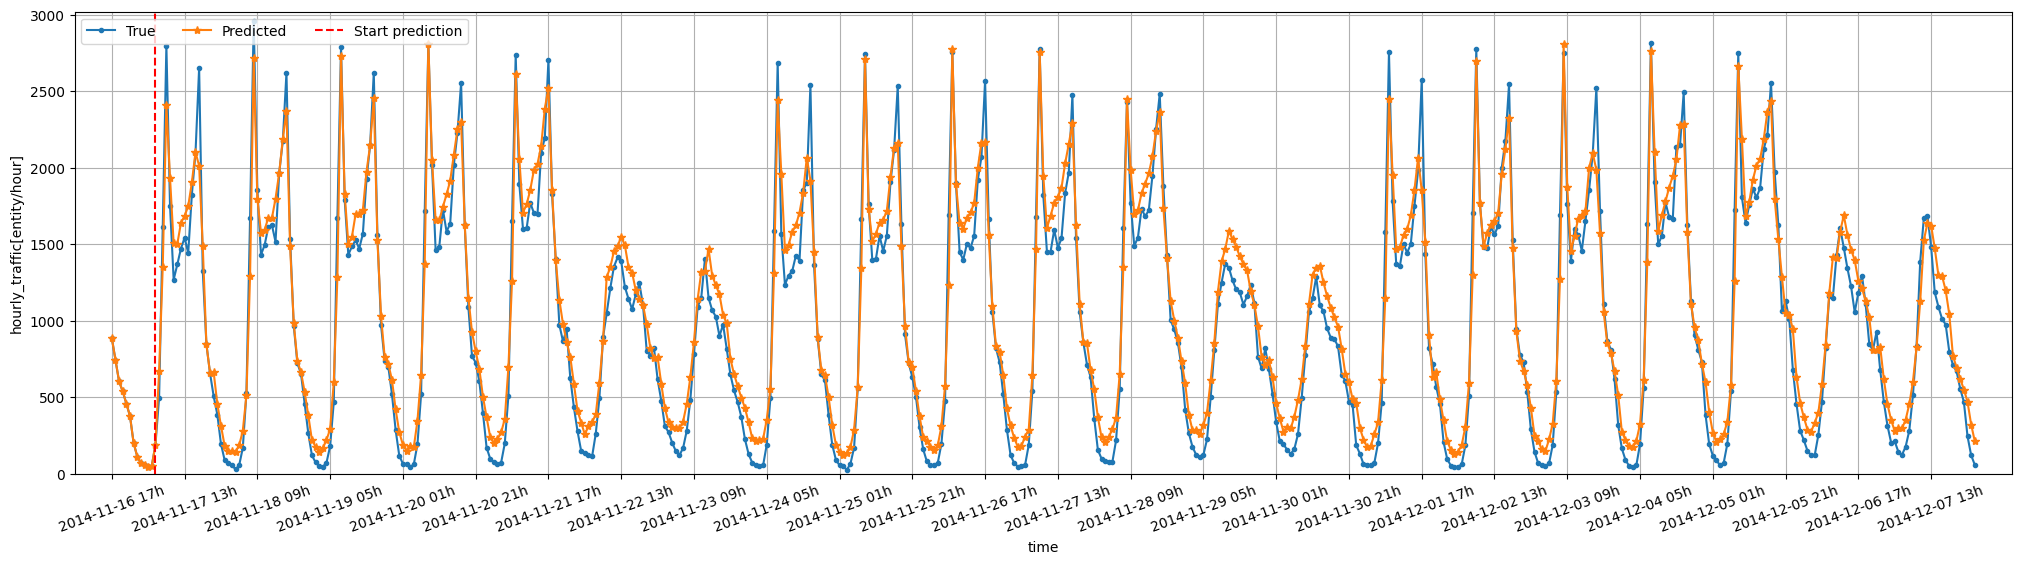


Prediction Scores:
272/272 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step
mean_squared_error: 0.0102(0.1010) - mean_absolute_error: 0.0806
DeNorm_mean_squared_error: 32895.1680(181.3703) - DeNorm_mean_absolute_error: 145.0645


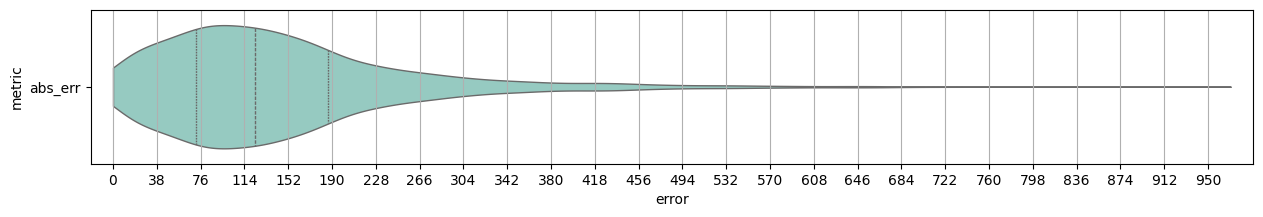

,mean,std,min,25%,50%,75%,max
error,145.064525,108.870623,0.007473,72.227717,123.535055,186.743964,969.730289


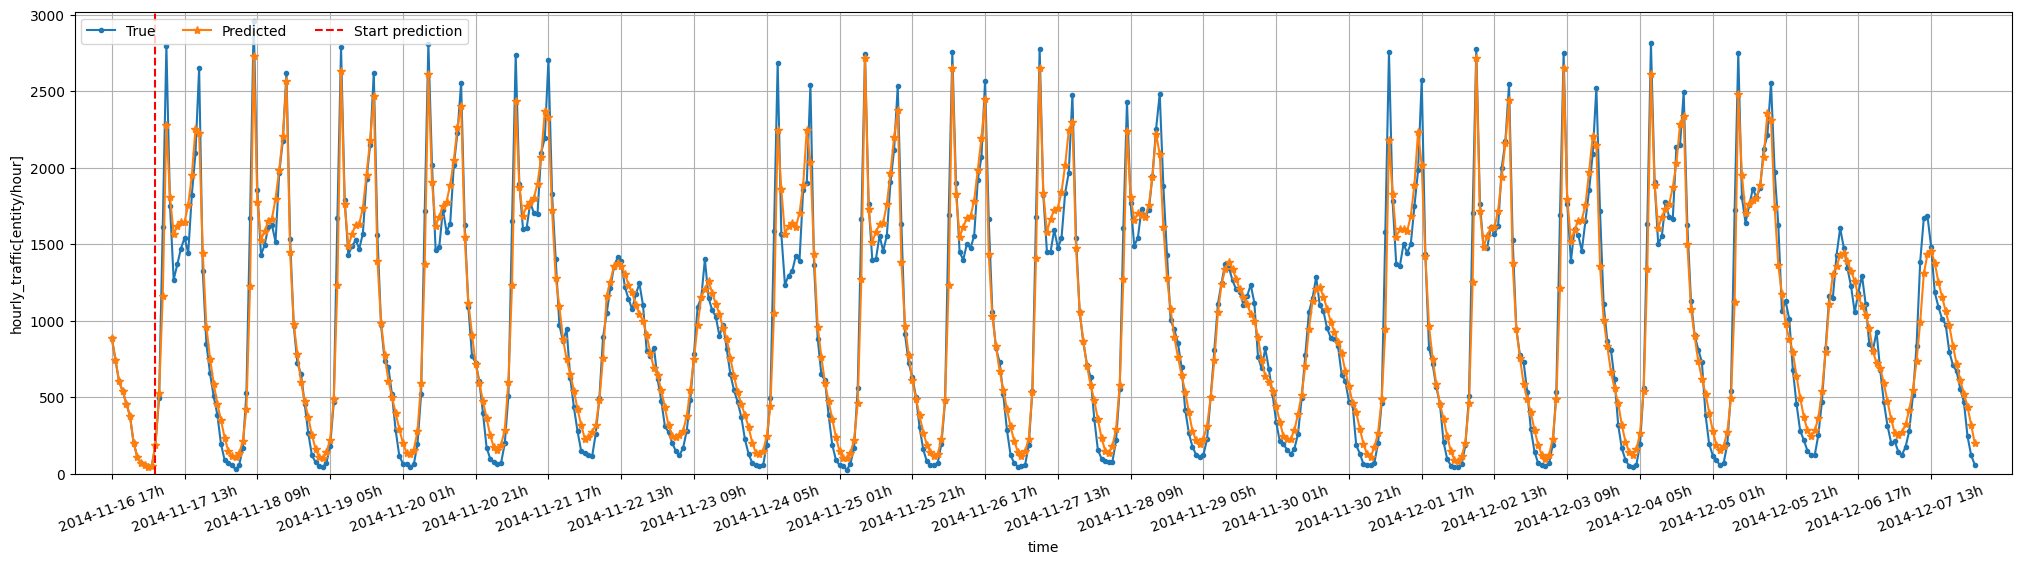


Prediction Scores:
272/272 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step
mean_squared_error: 0.0067(0.0819) - mean_absolute_error: 0.0646
DeNorm_mean_squared_error: 21568.5469(146.8623) - DeNorm_mean_absolute_error: 116.2275


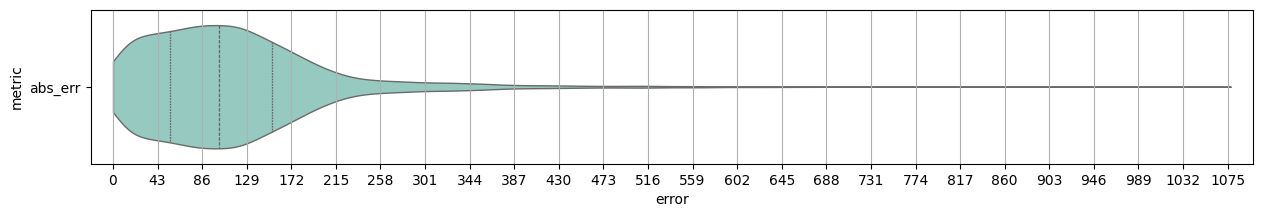

,mean,std,min,25%,50%,75%,max
error,116.227458,89.781139,0.078904,54.749077,102.741429,152.93626,1078.048201


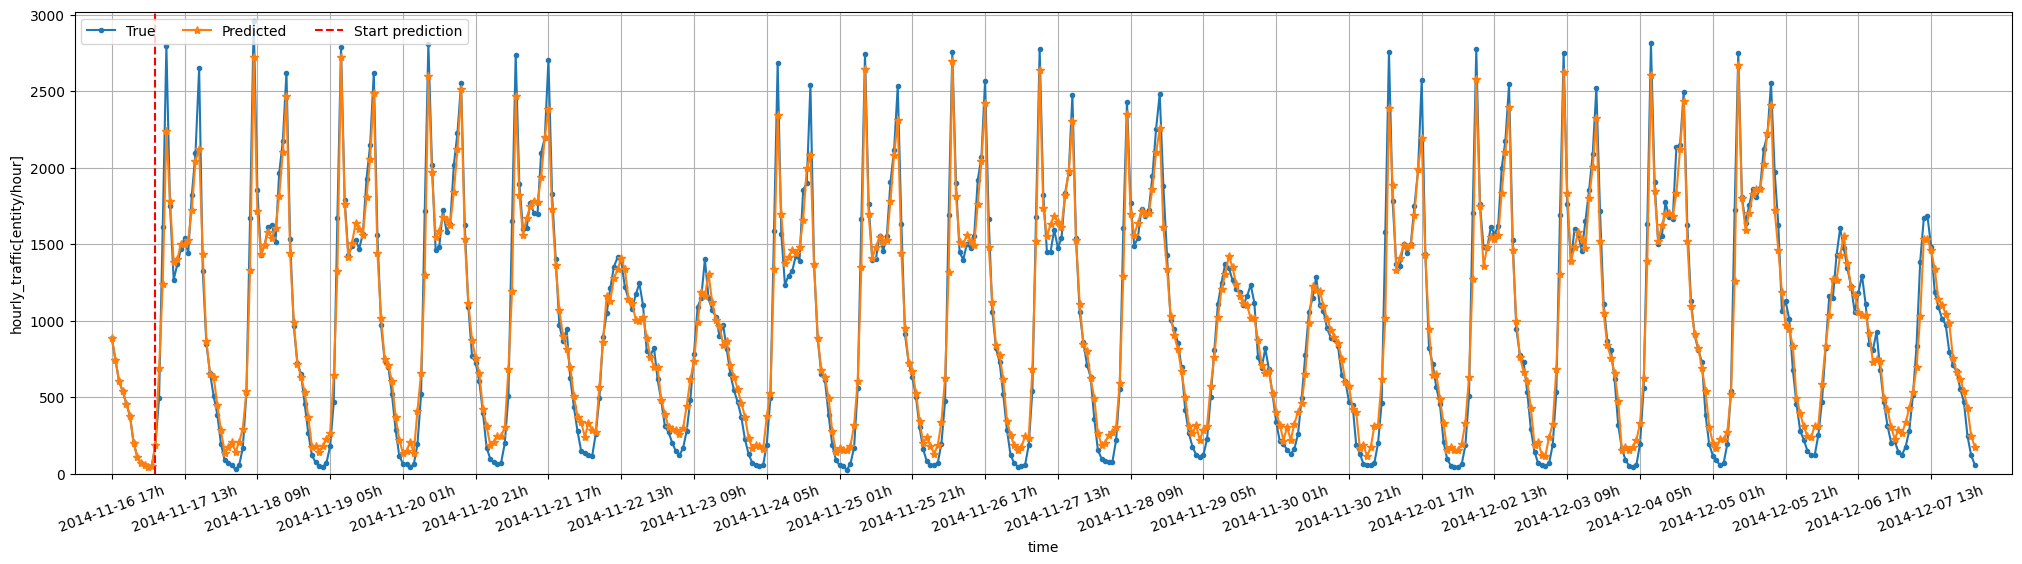

In [23]:
pred_stackedLSTM, _ = trainer.predict_and_compare(model_stacked_lstm, Test, plot_range, do_plot = True)
pred_stackedLSTM_modif, _ = trainer.predict_and_compare(model_lstm_modif, Test, plot_range, do_plot = True)
pred_GRU, _ = trainer.predict_and_compare(model_GRU, Test, plot_range, do_plot = True)